In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

##set the font globally
plt.rcParams.update({'font.family':'Helvetica'})


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ternary # ternary plot has a bug
import plotly.express as px
import h5py
import matplotlib as mpl

# import geopandas as gpd

from matplotlib.patches import Circle, Wedge, Polygon

import os
import matplotlib.patheffects as path_effects


from netCDF4 import Dataset as NetCDFFile 

from obspy.imaging.beachball import beach

# for beachball - there are some error with using obspy
from pyrocko.plot import beachball
from pyrocko import moment_tensor as ptm

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from pathlib import Path
%matplotlib inline

import harmonica as hm

from obspy.core import UTCDateTime

from matplotlib.patches import Polygon

import seaborn as sns
sns.set()
sns.set_style(style='white') 
sns.set_style("ticks", {"xtick.major.size": 0.5, "ytick.major.size": 0.5})

# set the font globally
plt.rcParams.update({'font.family':'Helvetica'})

In [19]:
def get_max_curv (mag, mag_bin = 0.1):

    m_bins, cum_mag, non_cum_mag = get_freq_mag_dist(mag, mag_bin)
    m_cutoff = m_bins[non_cum_mag == non_cum_mag.max()]

    return m_cutoff



def get_freq_mag_dist(mag, mag_bin = 0.1, debug = False):
    '''
    Calculates the frequency-magnitude distribution of a seismic catalogue
    Inputs: 
    mag - array containing magnitude of events
    mag_bin - bin size to use
    Returns:
    m_vals - magnitude values in distribution
    cum_mag - cumulative magnitude distribution
    non_cum_mag - non-cumulative magnitude distribution
    '''
    
    # create mag bins
    min_val = min(round(mag/mag_bin)*mag_bin)
    max_val = max(round(mag/mag_bin)*mag_bin)
    m_vals = np.arange(min_val, max_val, mag_bin)

    # nbm =m_vals.shape[0]
    cum_mag = np.zeros_like(m_vals) # cumulative magnitude
    if debug:
        print(cum_mag.shape)
        print(m_vals.shape)
    
    # calculated cumulative moment distribution 
    for i in np.arange(m_vals.shape[0]):
        cum_mag[i] = (mag > (m_vals[i] - mag_bin/2)).sum()

    # calculated non-cumulative moment
    dummy_cum_mag = np.concatenate([cum_mag, [0]])
    non_cum_mag = np.abs(dummy_cum_mag[1:] - dummy_cum_mag[:-1])

    return (m_vals, cum_mag, non_cum_mag)


In [20]:
data = pd.read_csv("/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/sam_class_by_loc.csv", header = 'infer')
data_jpn = pd.read_csv("/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/ryu_kur_class_by_loc_net.csv", header = 'infer')

data.columns = data_jpn.columns

In [21]:
data.sort_values(by = 'MW', ascending = False, inplace = True)

data['DATE'] = pd.to_datetime(data['DATE']) # change dtype to datetime format
data['DATE'] = data['DATE'].dt.strftime('%Y-%m-%d') # change dtype to object

# data['DATE'] and data['TIME'] should be object (str) to perform + operator

data_dummy = np.array(data['DATE'] + ' ' + data['TIME'])

data_ev_time = []

for val in data_dummy:
    data_ev_time.append(UTCDateTime(val))

    
ref_date = data_ev_time[0]

data_ev_time = np.array(data_ev_time)

date = []

for val in data_ev_time:
    date.append(val - ref_date)
    
date = np.array(date) # this is in seconds

data['YEARS'] = date/31536000

data = data.sort_values(by ='YEARS', ascending=True) # this is an important step
# data = data[(data['DATE'] > '01-01-2003') & (data['DATE'] < '26-11-2004')]

# data = data[(data['CLASS'] == 'MTHRUST')]
data = data[(data['CLASS'] == 'DGOING')]
# data = data[(data['CLASS'] == 'UPPER') &
#             (data['LAT'] > -6) & (data['LAT'] < 6) &
#            (data['DEPTH'] > 0)]

In [22]:
test_df = data

# some parameters here
mbin = 0.1
num_runs = 300 # bootstrapping to get some spread

# open test file
# test_df = pd.read_csv(test_file, header  = 'infer', sep = ',')
# test_df = test_df[test_df["AUTHOR"].isin(["GCMT", "gcmt"])]
# print(test_df.shape)


In [23]:
# run the function
m_cut_arr = np.zeros(num_runs)
num_ev = test_df["MW"].shape[0]

for i in np.arange(num_runs):
    mw_sample = test_df["MW"].sample(num_ev, replace = True)
    m_cut = get_max_curv(mw_sample)
    if len(m_cut > 0): # happens sometimes
        m_cut = m_cut.mean()
    m_cut_arr[i] = m_cut


m_cut = m_cut_arr.mean()
m_cut_err = m_cut_arr.std()

print("cut-off magnitude: ", m_cut)
print("cut-off error: ", m_cut_err)

# calculate b-value using maximum likelihood (Aki 1965)
# another way of computing b
ev_above_cut = test_df[test_df['MW'] > m_cut]
diff_mag = (ev_above_cut["MW"] - m_cut - mbin/2)
b_est2 = 1/diff_mag.mean()
b_est2 = b_est2/np.log(10)
b_err2 = b_est2/np.sqrt(ev_above_cut.shape[0])

print("Estimated b-value: ", b_est2)
print("b-value error: ", b_err2)

# print("Second estimated b-value: ", b_est2)
# print("Second b-value error: ", b_err2)


cut-off magnitude:  5.32783333333
cut-off error:  0.0587393016264
Estimated b-value:  0.979611113621
b-value error:  0.0360844391516


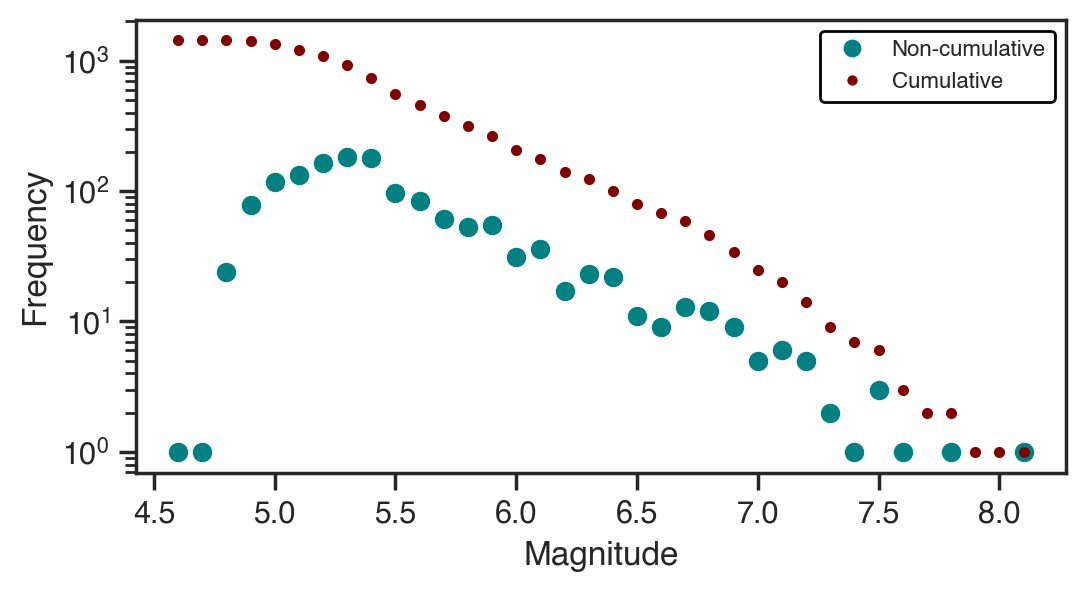

In [24]:
# look at the hist for the entire catalog
m_vals, cum_mag, non_cum_mag = get_freq_mag_dist(test_df["MW"], mag_bin = 0.1)

figsize = (6,3)
fig, ax = plt.subplots(dpi = 200, figsize= figsize)
ax.plot(m_vals, non_cum_mag, 'o', label = "Non-cumulative", color = 'teal')
ax.plot(m_vals, cum_mag, '.',label = "Cumulative", color = 'maroon')
ax.set_xlabel("Magnitude")
ax.set_ylabel("Frequency")
ax.set_yscale("log")
ax.legend(loc = 'upper right',
            fontsize = 8,
            facecolor="white",
            framealpha=1,
            edgecolor="black",
            markerscale=0.9)

# ax.axvline(x=5, color='black', lw=0.5, ls='-', alpha=1)

# ax.text(5.8,30, 'Sumatra Upper Plate \n$M_c$ = 5.0 \nb-value = 0.95',
#         color='black', fontsize=8, ha='left')

# plt.savefig("/Users/mohd0001/PhD_Monash/Paper2/output/GR_SUM_UP.png" #intermediate #shallow #deep #SUM_UP
#             , dpi = 500, transparent= True, bbox_inches='tight')